In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

Model:  [5.55949233 8.27793055]


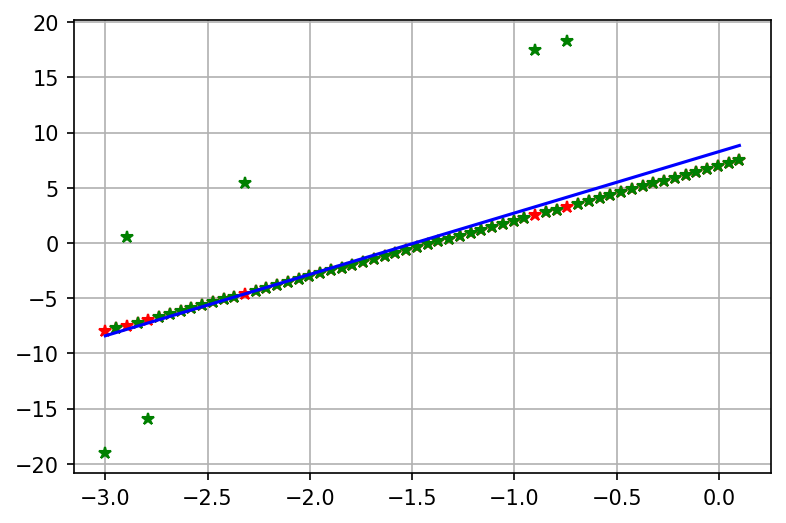

In [2]:
start = -3
stop = 3
step = 0.1
samples = int((stop - start) / step) #liczba próbek
x = np.linspace(start, step, samples) #wygenerowanie zakresu zmiennej x

y = 5*x + 7 #wygenerowanie wartosci y

X = np.array([ #zdefinioanie modelu
    x**1, x**0]).T

y_outlier = y.copy() #skopiowanie wartosci y i dodanie wartosci odstajacych
y_outlier[13] += 10
y_outlier[0] -= 11
y_outlier[2] += 8
y_outlier[4] -= 9
y_outlier[40] += 15
y_outlier[43] += 15

model = np.linalg.inv(X.T @ X) @ X.T @ y_outlier #wyznaczenie modelu z aproksymacji (metoda najmniejszych kwadratów)

print("Model: ", model)

y_new = X @ model #wyznaczenie nowych wartosci y wedlug modelu

plt.figure(dpi=150) #przedstawienie wykresów
plt.plot(x, y, "r*") #wykres y dla x
plt.plot(x, y_outlier, 'g*') #wykres z odstajacymi wartosciami
plt.plot(x, y_new, "b-") #wykres dopasowania do modelu
plt.grid(True)
plt.show()

#model odbiega, przez odstajace punkty
#do wyznaczenia odstajacyh punktów wykorzystujemy algorytm RANSAC 

Best model:  [5. 7.]
Best ratio:  0.9


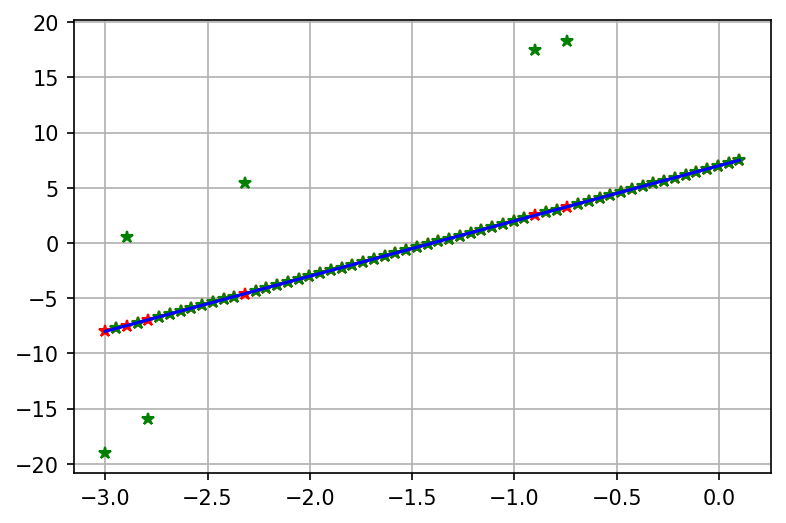

In [314]:
start = -3
stop = 3
step = 0.1
samples = int((stop - start) / step) #liczba próbek
x = np.linspace(start, step, samples) #wygenerowanie zakresu zmiennej x

y = 5*x + 7 #+ np.random.normal(0, 0.2, size=x.shape) #wygenerowanie wartosci y

X = np.array([ #zdefinioanie modelu
    x**1, x**0]).T

y_outlier = y.copy() #skopiowanie wartosci y i dodanie wartosci odstajacych
y_outlier[13] += 10
y_outlier[0] -= 11
y_outlier[2] += 8
y_outlier[4] -= 9
y_outlier[40] += 15
y_outlier[43] += 15

#parametry algorytmu RANSAC
num_iters = 100 #liczba iteracji
sample_size = 2 #najmniejsza liczba punktów ktore są potrzebne do wyznaczenia parametru modelu
threshold = 0.1 #próg, kiedy dany parametr można uznać za bycie w zakresie naszego modelu
min_ratio = 0.85 

indices = np.arange(len(X)) #tablica indeksów X
best_ratio = -np.inf #poczatkowa wartosci best_ratio

for i in range(num_iters): #pętla do liczenia algorytmu RANSAC
    # 1) Losowe wybranie sampli
    random_indices = np.random.choice(indices, size=sample_size, replace=False) #wygenerowanie losowych indeksów
    #print(random_indices)
    sample_X = X[random_indices, :] #ideksowanie X
    sample_y = y_outlier[random_indices] #indeksowanie y
    current_model = np.linalg.inv(sample_X.T @ sample_X) @ sample_X.T @ sample_y #obliczenie modelu dla losowych indeksów
    #print("Current model: ", current_model)
    transformed = X @ current_model #wyzaczenie wartosci dla wyliczonego modelu
    error = (transformed - y_outlier)**2 #obliczenie błedu średnio-kwadratowego
    inliers = np.sum(error < threshold) #wyznaczenie punktów zawieracjacych się w zakresie
    ratio = inliers / len(error) #wyznaczenie stosunku ilosci poprawnych wartosci do calosci
    #algorytm rancas zakłada że outliers jest znacznie mniej niz inliners
    #print("Ratio: ", ratio)
    if ratio > best_ratio: #wyznaczenie najlepszego modelu
        best_ratio = ratio
        best_model = current_model
    if best_ratio > min_ratio: #wyznaczenie najlepszego ratio 
         break #przerwanie pętli gdy znajdziemy best ratio
            
#transfomormed = X @ best_model
#error = (transformed - y_outlier)**2
#wrong_indices = []
#for j in range(len(error)):
    #if ((error[j]*(threshold*(0.9-best_ratio))) < (threshold/best_ratio)) == False:
        #wrong_indices.append(j)   
    
#print("Indeksy wartości odstających:", wrong_indices)
#print("Prawdziwe indeksy wartości odstających:", [0, 2, 4, 13, 40, 43], "\n")
        
        
print("Best model: ", best_model)
print("Best ratio: ", best_ratio)

y_new = X @ best_model #wyznaczenie nowych wartosci y wedlug modelu

plt.figure(dpi=150) #przedstawienie wykresów
plt.plot(x, y, "r*") #wykres y dla x
plt.plot(x, y_outlier, 'g*') #wykres z odstajacymi wartosciami
plt.plot(x, y_new, "b-") #wykres dopasowania do modelu
plt.grid(True)
plt.show()

In [5]:
#Funckje do liczenia algorytmu RANSAC

def data_sampler(data, sample_size): #zdefiniowanie funkcjii do losowania sampli
    indices = np.arange(len(data)) #liczba indeksów
    random_indices = np.random.choice(indices, size=sample_size, replace=False) #losowe indeksy
    sample = data[random_indices, :] 
    return sample #zwrocenie sampli

def model_calculator(data): #zdefiniowanie funkcji do obliczenia modelu
    return np.linalg.inv(data[:, :-1].T @ data[:, :-1]) @ data[:, :-1].T @ data[:, -1]

def model_evaluator(data, model): #zdefiniowanie funkcji do ewaluacji modelu
    return data[:, :-1] @ model 

def ratio_calculator(transformed_data, data, threshold): #zdefiniowanie funkcji do obliczania ratio
    error = (transformed_data - data[:, -1])**2
    inliers = np.sum(error < threshold)
    ratio = inliers / len(error)
    return ratio

def ransac(data, data_sampler, model_calculator, model_evaluator, ratio_calculator, threshold, sample_size, max_iters, min_ratio):
    best_ratio = -np.inf #wartosci poczatkowa
    best_model = None #wartosc poczatkowa
    for i in range(max_iters): #algorytm RANSAC
        sample = data_sampler(data, sample_size) #losowanie sampli do testu
        current_model = model_calculator(sample) #wyznaczenie modelu na samplach
        transformed = model_evaluator(data, current_model) #ewualowanie modelu
        ratio = ratio_calculator(transformed, data, threshold) #obliczenie stosunku inliners
        if ratio > best_ratio: #wyznaczenie najlepszego modelu
            best_ratio = ratio
            best_model = current_model
        if best_ratio > min_ratio: #wyzaczenie najlepszego ratio
            break
            
    return best_ratio, best_model #zwrocenie wartosci najlepszego modelu i ratio

In [21]:
#ZADANIE 1
#Zmodyfikuj algorytm RANSAC z zajęć w taki sposób, aby zwracał indeksy odpowiadające danym wejściowych, 
#które można potraktować jako wartości odstające.

def ransac_indices(data, data_sampler, model_calculator, model_evaluator, ratio_calculator, threshold, sample_size, max_iters, min_ratio):
    best_ratio = -np.inf #wartosci poczatkowa
    best_model = None #wartosc poczatkowa
    for i in range(max_iters): #algorytm RANSAC
        sample = data_sampler(data, sample_size) #losowanie sampli do testu
        current_model = model_calculator(sample) #wyznaczenie modelu na samplach
        transformed = model_evaluator(data, current_model) #ewualowanie modelu
        ratio = ratio_calculator(transformed, data, threshold) #obliczenie stosunku inliners
        if ratio > best_ratio: #wyznaczenie najlepszego modelu
            best_ratio = ratio
            best_model = current_model
        if best_ratio > min_ratio: #wyzaczenie najlepszego ratio
            break
            
    print("Best model: ", best_model)
    print("Best ratio: ", best_ratio)       
            
    transformed = model_evaluator(data, best_model)
    #print(transformed)
    #print(y_outlier)
    error = (transformed - y_outlier)**2
    #print(error)
    #print(error < threshold)

    wrong_indices = [] #tablica odstajacych indeksów
    for j in range(len(error)): #petla do liczenia indeksow outliners
        if ((error[j]*(threshold*(0.90 - best_ratio))) < (threshold/best_ratio)) == False:
        #if (error[j] < threshold) == False:
            wrong_indices.append(j) #dodanie indesku do tablicy 
            
    return wrong_indices #zwrocenie tablicy z odstajacymi indeksami



Best model:  [4.91193417 6.86515443]
Best ratio:  0.8

Indeksy wartości odstających: [0, 2, 4, 13, 40, 43]
Prawdziwe indeksy wartości odstających: [0, 2, 4, 13, 40, 43] 



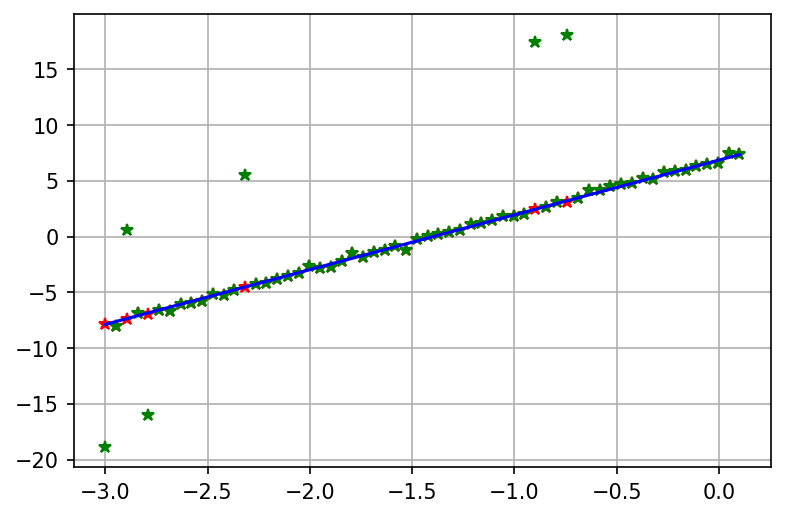

In [31]:
start = -3
stop = 3
step = 0.1
samples = int((stop - start) / step) #liczba próbek
x = np.linspace(start, step, samples) #wygenerowanie zakresu zmiennej x

y = 5*x + 7 + np.random.normal(0, 0.2, size=x.shape) #wygenerowanie wartosci y

X = np.array([ #zdefinioanie modelu
    x**1, x**0]).T

y_outlier = y.copy() #skopiowanie wartosci y i dodanie wartosci odstajacych
y_outlier[13] += 10
y_outlier[0] -= 11
y_outlier[2] += 8
y_outlier[4] -= 9
y_outlier[40] += 15
y_outlier[43] += 15

#parametry algorytmu RANSAC
num_iters = 100 #liczba iteracji
sample_size = 2 #najmniejsza liczba punktów ktore są potrzebne do wyznaczenia parametru modelu
threshold = 0.1 #próg, kiedy dany parametr można uznać za bycie w zakresie naszego modelu
min_ratio = 0.85 

#print(y_outlier)
data = np.hstack([X, y_outlier[:, np.newaxis]]) #dodanie do X wartosci z y_outliers
#print(y_outlier[:, np.newaxis])

best_ratio, best_model = ransac(data, data_sampler, model_calculator, model_evaluator, ratio_calculator, threshold, sample_size, num_iters, min_ratio)

bad_indices = ransac_indices(data, data_sampler, model_calculator, model_evaluator, ratio_calculator, threshold, sample_size, num_iters, min_ratio)

#print("Best model: ", best_model)
#print("Best ratio: ", best_ratio)


print("\nIndeksy wartości odstających:", bad_indices)
print("Prawdziwe indeksy wartości odstających:", [0, 2, 4, 13, 40, 43], "\n")

y_new = X @ best_model #wyznaczenie nowych wartosci y wedlug modelu

plt.figure(dpi=150) #przedstawienie wykresów
plt.plot(x, y, "r*") #wykres y dla x
plt.plot(x, y_outlier, 'g*') #wykres z odstajacymi wartosciami
plt.plot(x, y_new, "b-") #wykres dopasowania do modelu
plt.grid(True)
plt.show()

Best model:  [4.97076624 6.99789553 5.01491077]
Best ratio:  0.7666666666666667

Indeksy wartości odstających: [0, 2, 4, 13, 40, 43]
Prawdziwe indeksy wartości odstających: [0, 2, 4, 13, 40, 43] 



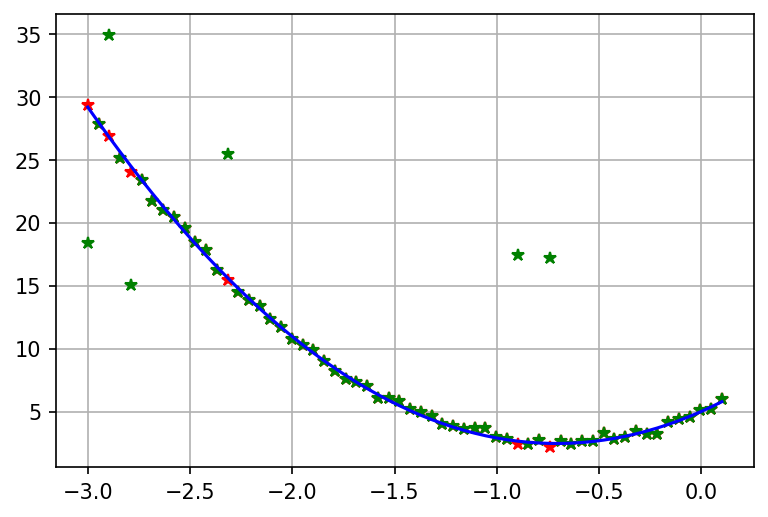

In [23]:
start = -3
stop = 3
step = 0.1
samples = int((stop - start) / step) #liczba próbek
x = np.linspace(start, step, samples) #wygenerowanie zakresu zmiennej x


y = 5*x**2 + 7*x + 5 + np.random.normal(0, 0.2, size=x.shape) #wygenerowanie wartosci y

X =np.array([ #zdefinioanie modelu
    x**2, x**1, x**0]).T

y_outlier = y.copy() #skopiowanie wartosci y i dodanie wartosci odstajacych
y_outlier[13] += 10
y_outlier[0] -= 11
y_outlier[2] += 8
y_outlier[4] -= 9
y_outlier[40] += 15
y_outlier[43] += 15

#parametry algorytmu RANSAC
num_iters = 100 #liczba iteracji
sample_size = 5 #najmniejsza liczba punktów ktore są potrzebne do wyznaczenia parametru modelu
threshold = 0.1 #próg, kiedy dany parametr można uznać za bycie w zakresie naszego modelu
min_ratio = 0.85 

data = np.hstack([X, y_outlier[:, np.newaxis]]) #dodanie do X wartosci z y_outliers

_, best_model = ransac(data, data_sampler, model_calculator, model_evaluator, ratio_calculator, threshold, sample_size, num_iters, min_ratio)

bad_indices = ransac_indices(data, data_sampler, model_calculator, model_evaluator, ratio_calculator, threshold, sample_size, num_iters, min_ratio)


print("\nIndeksy wartości odstających:", bad_indices)
print("Prawdziwe indeksy wartości odstających:", [0,2,4, 13, 40,43], "\n")

#print("Best model: ", best_model)

y_new = X @ best_model #wyznaczenie nowych wartosci y wedlug modelu

plt.figure(dpi=150) #przedstawienie wykresów
plt.plot(x, y, "r*") #wykres y dla x
plt.plot(x, y_outlier, 'g*') #wykres z odstajacymi wartosciami
plt.plot(x, y_new, "b-") #wykres dopasowania do modelu
plt.grid(True)
plt.show()

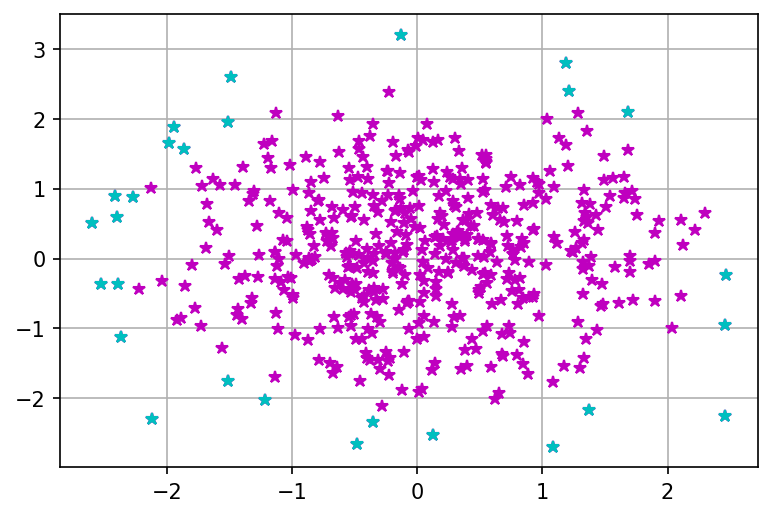

In [365]:
# ZADANIE 2
#Zaimplementuj prostą metodę detekcji wartości odstających opartej na rozkładzie Gaussa (anomaly detection 
#using Gaussian distribution) dla danych 2-D.

A = np.random.randn(500, 2)

def gaussian_anomaly_detector(X, threshold):
    
    mean = np.sum(X, 0) / len(X) #obliczenie średniej
    var =  np.sum((X - mean)**2, axis = 0) / len(X) #obliczenie odchylenia standardowego
    
    var = np.reshape(var, (1, 2)) #zmiana ksztaltu tablicy odchylenia na 2D 

    n = np.size(var, 1) #obliczenie dlugosci tablicy odchylenia

    if np.size(var, 1)== 1 or np.size(var, 0) == 1: 
        var = np.diag(var[0,:]) #zmiana odchylenia na macierz diagonalną
    
    inv = np.linalg.inv(var) #odwrócenie macierzy odchylenia
    det = np.linalg.det(var) #obliczenie wyznacznika macierzy odchylenia
    
    e = -0.5 * np.sum(np.multiply((X-mean @ inv), X-mean) , 1) #potęga e
    p = ((2*np.pi)**-(n/2)) * (det**-0.5) * np.exp(e) #Obliczenie prawdopodobienstwa p 
                
    ind = [] #zdefiniowanie pustej tabliy
    
    for i in range(len(p)): #petla do obliczenia wartosci odstających
        if p[i] < threshold: #warunek odstawania
            ind.append(i) #dodanie wspolrzednych odstajacych elementow

    return ind #zwrocenie tablicy z odstajacycmi wsprzednymi

    
indices = gaussian_anomaly_detector(A, 0.01) #obliczenie odstajacych wspolrzednych

plt.figure(dpi=150) #przedstawienie wykresów
plt.plot(A[:,0], A[:, 1], "m*") #wykres wszystkich punktow
plt.plot(A[indices,0], A[indices, 1], "c*") #wykrres odstajacych punktow
plt.grid(True)
plt.show()
